<a href="https://colab.research.google.com/github/azullah/PlantTraits2024_Kaggle/blob/main/Submit_Final_project_PlantTraits2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DTSA - 5511 Deeplearning - Final Project Kaggle Challenge
## PlantTraits2024 - FGVC11
Uncovering the biosphere: Predicting 6 Vital Plant Traits from Plant Images for Ecosystem Health

Kaggle Link: https://www.kaggle.com/competitions/planttraits2024/overview

The objective of this project is to classify the open-sourced plant images into 6 plant traits (such as leaf area, plant height etc). In addition to the image data, the project also provides related data (based on geo-location of the images) such as Climate, Soil and Sattelite data.

#### From the Kaggle Project description

This competition aims to predict plant properties - so called plant traits - from citizen science plant photographs. Why are plant traits currently so relevant? Plant traits are plant properties that are used to describe how plants function how they interact with the environment. For instance, the trait of plant canopy height indicates how good a plant is at overshadowing its neightbors in the competition for sun light. Robust leaves (indicated by the leaf mass pear leaf area) indicate that plants optimize towards extreme conditions, such as heavy winds or droughts. Yet, environmental conditions are not static. Due to global change, the biosphere is being transformed at accelerating pace. Especially climate change is assumed to drastically impact the functioning of the ecosystems. This includes several processes, e.g. adaptions of plants and their traits to new conditions or even a altered plant species distribution with a resulting modification of the distribution of plant traits. However, we can hardly project on a global scale how plant traits and as such entire ecosystems will react to climate change because we do not have sufficient data on plant traits.

A data treasure in this regard may be the growing availability of citizen science photographs. Thousands of citizens around the globe photograph plants with species identification apps (examples are iNaturalist or Pl@ntNet). The species are identified using AI algorithms, and the prediction, photograph, and geolocation are curated in open databases. There are already more than 20 million plant photographs available, covering all ecosystem types and continents.

## Dataset Description

**Files**:

- `train_images` - The folder with the training images (.jpeg)

- `train.csv` - The labels and the ancillary data (satellite data, soil data, climate data etc.) for each training image

- `test_images` - The folder with the test images (.jpeg) that shall be used to create the predictions for the submission.

- `test.csv` - The ancillary data (satellite data, soil data, climate data etc.) for each test image

- `target_name_meta.csv` - full names of the traits obtained from the TRY database. This is important to understand what all traits are we predicting

- `sample_submission.csv` - a sample submission file in the correct format



## Get the data  
Copy and Unzip files from Google drive
The zip data file was earlier copied from the Kaggle project `planttraits2024` dataset to my personal google drive.

[Instructions on using the Kaggle API can be found here](https://towardsdatascience.com/downloading-kaggle-datasets-directly-into-google-colab-c8f0f407d73a)

In [1]:
# Complete path to storage location of the .zip file of data
# Mount google drive
import os
from google.colab import drive
drive.mount('/gdrive')

zip_path = '/gdrive/MyDrive/kaggle/planttraits2024.zip'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
print(os.getcwd())
# Copy the .zip file into the present directory
!cp '{zip_path}' .
# Unzip quietly
!unzip -q 'planttraits2024.zip'
# View the unzipped contents in the virtual machine
os.listdir()

Mounted at /gdrive
/content


['.config',
 'train_images',
 'test.csv',
 'test_images',
 'sample_submission.csv',
 'target_name_meta.tsv',
 'train.csv',
 'planttraits2024.zip',
 'sample_data']

**Import all required libraries**

In [2]:
!pip install -q keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, Concatenate
import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as k
import keras.utils as image
print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


In [3]:
import os
os.listdir()

['.config',
 'train_images',
 'test.csv',
 'test_images',
 'sample_submission.csv',
 'target_name_meta.tsv',
 'train.csv',
 'planttraits2024.zip',
 'sample_data']

## Exploratory Data Analysis

### Read the Training labels and anciliary data file
This is a csv file with the image ID,  ancilliary data(climate, soil, satellite etc.) and the label.

*Note: The image files are .jpeg files with the image ID as their name*

In [4]:
train = pd.read_csv('./train.csv')
print(train.shape)

(55489, 176)


In [5]:
train.head()

id  WORLDCLIM_BIO1_annual_mean_temperature  \
0  192027691                               12.235703   
1  195542235                               17.270555   
2  196639184                               14.254504   
3  195728812                               18.680834   
4  195251545                                0.673204   

   WORLDCLIM_BIO12_annual_precipitation  \
0                            374.466675   
1                             90.239998   
2                            902.071411   
3                           1473.933350   
4                            530.088867   

   WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                          62.524445                       
1                                          10.351111                       
2                                          49.642857                       
3                                         163.100006                       
4                                          50.857777                       

   WORLDCLIM_BIO15_precipitation_seasonality  \
0                                  72.256844   
1                                  38.220940   
2                                  17.873655   
3                                  45.009758   
4                                  38.230709   

   WORLDCLIM_BIO4_temperature_seasonality  \
0                              773.592041   
1                              859.193298   
2                              387.977753   
3                              381.053986   
4                             1323.526855   

   WORLDCLIM_BIO7_temperature_annual_range  SOIL_bdod_0.5cm_mean_0.01_deg  \
0                                33.277779                            125   
1                                40.009777                            124   
2                                22.807142                            107   
3                                20.436666                            120   
4                                45.891998                             91   

   SOIL_bdod_100.200cm_mean_0.01_deg  SOIL_bdod_15.30cm_mean_0.01_deg  ...  \
0                                149                              136  ...   
1                                144                              138  ...   
2                                133                              119  ...   
3                                131                              125  ...   
4                                146                              120  ...   

   X18_mean   X26_mean  X50_mean   X3112_mean     X4_sd    X11_sd    X18_sd  \
0  0.117484   1.243779  1.849375    50.216034  0.008921  1.601473  0.025441   
1  0.389315   0.642940  1.353468   574.098472  0.003102  0.258078  0.000866   
2  8.552908   0.395241  2.343153  1130.096731       NaN       NaN       NaN   
3  1.083629   0.154200  1.155308  1042.686546  0.011692  2.818356  0.110673   
4  0.657585  10.919966  2.246226  2386.467180  0.006157  1.128000  0.026996   

     X26_sd    X50_sd    X3112_sd  
0  0.153608  0.279610   15.045054  
1  0.034630  0.010165   11.004477  
2       NaN       NaN         NaN  
3  0.011334  0.229224  141.857187  
4  0.553815  0.107092   87.146899  

[5 rows x 176 columns]

**Read the metadata file for label names**

In [6]:
label_names = pd.read_table('./target_name_meta.tsv')
pd.set_option('display.max_colwidth', None)
label_names

trait_ID  \
0       X4   
1      X11   
2      X18   
3      X26   
4      X50   
5    X3112   

                                                                           trait_name   
0   Stem specific density (SSD) or wood density (stem dry mass per stem fresh volume)   
1                      Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA)   
2                                                                        Plant height   
3                                                                       Seed dry mass   
4                                             Leaf nitrogen (N) content per leaf area   
5  Leaf area (in case of compound leaves: leaf, undefined if petiole in- or excluded)

**Get the label names from the target names metadata file**

The labels are given as mean values with their corresponding standard deviation.

In [7]:
class_names = list(label_names.trait_ID.astype('str')+'_mean')
print(class_names)
aux_class_names = list(map(lambda x: x.replace("mean","sd"), class_names))
print(aux_class_names)
num_classes = len(class_names)
num_classes_aux = len(aux_class_names)

['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']
['X4_sd', 'X11_sd', 'X18_sd', 'X26_sd', 'X50_sd', 'X3112_sd']


**Check the target columns values**

In [8]:
train[class_names].describe()

X4_mean      X11_mean      X18_mean      X26_mean       X50_mean  \
count  55489.000000  5.548900e+04  5.548900e+04  5.548900e+04   55489.000000   
mean       0.522575  1.325267e+02  1.969902e+04  3.459399e+03      13.528574   
std        0.174853  1.278220e+04  2.309747e+06  2.471919e+05    1356.480785   
min       -2.431157  6.780000e-05  2.330000e-08  5.500000e-07       0.000097   
25%        0.410995  1.063987e+01  3.102831e-01  5.613414e-01       1.173489   
50%        0.509009  1.511232e+01  7.156651e-01  2.519985e+00       1.480060   
75%        0.622383  1.968160e+01  3.586311e+00  1.491886e+01       1.926343   
max        4.475172  1.504254e+06  2.720494e+08  3.106555e+07  159759.897700   

         X3112_mean  
count  5.548900e+04  
mean   3.975552e+05  
std    9.152463e+07  
min    7.690000e-08  
25%    2.552815e+02  
50%    7.244318e+02  
75%    2.148630e+03  
max    2.155911e+10

In [9]:
train[aux_class_names].describe()

X4_sd        X11_sd        X18_sd         X26_sd        X50_sd  \
count  39148.000000  39148.000000  39148.000000   39148.000000  39148.000000   
mean       0.007833      1.073573     16.003476     110.733150      0.075108   
std        0.012046      4.098486    881.605417    8361.855750      0.159520   
min        0.000000      0.000000      0.000000       0.000000      0.000000   
25%        0.003292      0.174866      0.029985       0.042226      0.017207   
50%        0.004996      0.357821      0.095136       0.238664      0.033162   
75%        0.007774      1.092862      0.330147       1.516574      0.082851   
max        0.284052    515.672017  63535.386846  739701.798818      9.729029   

            X3112_sd  
count   39148.000000  
mean      453.017146  
std      4196.228211  
min         0.000000  
25%        17.259899  
50%        63.322952  
75%       226.990400  
max    387491.201058

**Append `.jpeg` to image ID to get image filename**

In [10]:
train['image_id'] = train.id.astype(str) + '.jpeg'

In [11]:
train.head()

id  WORLDCLIM_BIO1_annual_mean_temperature  \
0  192027691                               12.235703   
1  195542235                               17.270555   
2  196639184                               14.254504   
3  195728812                               18.680834   
4  195251545                                0.673204   

   WORLDCLIM_BIO12_annual_precipitation  \
0                            374.466675   
1                             90.239998   
2                            902.071411   
3                           1473.933350   
4                            530.088867   

   WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                                              62.524445   
1                                                              10.351111   
2                                                              49.642857   
3                                                             163.100006   
4                                                              50.857777   

   WORLDCLIM_BIO15_precipitation_seasonality  \
0                                  72.256844   
1                                  38.220940   
2                                  17.873655   
3                                  45.009758   
4                                  38.230709   

   WORLDCLIM_BIO4_temperature_seasonality  \
0                              773.592041   
1                              859.193298   
2                              387.977753   
3                              381.053986   
4                             1323.526855   

   WORLDCLIM_BIO7_temperature_annual_range  SOIL_bdod_0.5cm_mean_0.01_deg  \
0                                33.277779                            125   
1                                40.009777                            124   
2                                22.807142                            107   
3                                20.436666                            120   
4                                45.891998                             91   

   SOIL_bdod_100.200cm_mean_0.01_deg  SOIL_bdod_15.30cm_mean_0.01_deg  ...  \
0                                149                              136  ...   
1                                144                              138  ...   
2                                133                              119  ...   
3                                131                              125  ...   
4                                146                              120  ...   

    X26_mean  X50_mean   X3112_mean     X4_sd    X11_sd    X18_sd    X26_sd  \
0   1.243779  1.849375    50.216034  0.008921  1.601473  0.025441  0.153608   
1   0.642940  1.353468   574.098472  0.003102  0.258078  0.000866  0.034630   
2   0.395241  2.343153  1130.096731       NaN       NaN       NaN       NaN   
3   0.154200  1.155308  1042.686546  0.011692  2.818356  0.110673  0.011334   
4  10.919966  2.246226  2386.467180  0.006157  1.128000  0.026996  0.553815   

     X50_sd    X3112_sd        image_id  
0  0.279610   15.045054  192027691.jpeg  
1  0.010165   11.004477  195542235.jpeg  
2       NaN         NaN  196639184.jpeg  
3  0.229224  141.857187  195728812.jpeg  
4  0.107092   87.146899  195251545.jpeg  

[5 rows x 177 columns]

**Replace missing values with zeroes in the target std deviation columns**

In [12]:
train[aux_class_names] = train[aux_class_names].fillna(0)
train.head()

id  WORLDCLIM_BIO1_annual_mean_temperature  \
0  192027691                               12.235703   
1  195542235                               17.270555   
2  196639184                               14.254504   
3  195728812                               18.680834   
4  195251545                                0.673204   

   WORLDCLIM_BIO12_annual_precipitation  \
0                            374.466675   
1                             90.239998   
2                            902.071411   
3                           1473.933350   
4                            530.088867   

   WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                                              62.524445   
1                                                              10.351111   
2                                                              49.642857   
3                                                             163.100006   
4                                                              50.857777   

   WORLDCLIM_BIO15_precipitation_seasonality  \
0                                  72.256844   
1                                  38.220940   
2                                  17.873655   
3                                  45.009758   
4                                  38.230709   

   WORLDCLIM_BIO4_temperature_seasonality  \
0                              773.592041   
1                              859.193298   
2                              387.977753   
3                              381.053986   
4                             1323.526855   

   WORLDCLIM_BIO7_temperature_annual_range  SOIL_bdod_0.5cm_mean_0.01_deg  \
0                                33.277779                            125   
1                                40.009777                            124   
2                                22.807142                            107   
3                                20.436666                            120   
4                                45.891998                             91   

   SOIL_bdod_100.200cm_mean_0.01_deg  SOIL_bdod_15.30cm_mean_0.01_deg  ...  \
0                                149                              136  ...   
1                                144                              138  ...   
2                                133                              119  ...   
3                                131                              125  ...   
4                                146                              120  ...   

    X26_mean  X50_mean   X3112_mean     X4_sd    X11_sd    X18_sd    X26_sd  \
0   1.243779  1.849375    50.216034  0.008921  1.601473  0.025441  0.153608   
1   0.642940  1.353468   574.098472  0.003102  0.258078  0.000866  0.034630   
2   0.395241  2.343153  1130.096731  0.000000  0.000000  0.000000  0.000000   
3   0.154200  1.155308  1042.686546  0.011692  2.818356  0.110673  0.011334   
4  10.919966  2.246226  2386.467180  0.006157  1.128000  0.026996  0.553815   

     X50_sd    X3112_sd        image_id  
0  0.279610   15.045054  192027691.jpeg  
1  0.010165   11.004477  195542235.jpeg  
2  0.000000    0.000000  196639184.jpeg  
3  0.229224  141.857187  195728812.jpeg  
4  0.107092   87.146899  195251545.jpeg  

[5 rows x 177 columns]

**Check if image_id matches the number of files in the train_images folder**

In [13]:
#train.image_id.head()
print(train['image_id'].count())
print(len(os.listdir('./train_images')))

55489
55489


**Extract some sample images from the training set**

We will also display the label values for each image

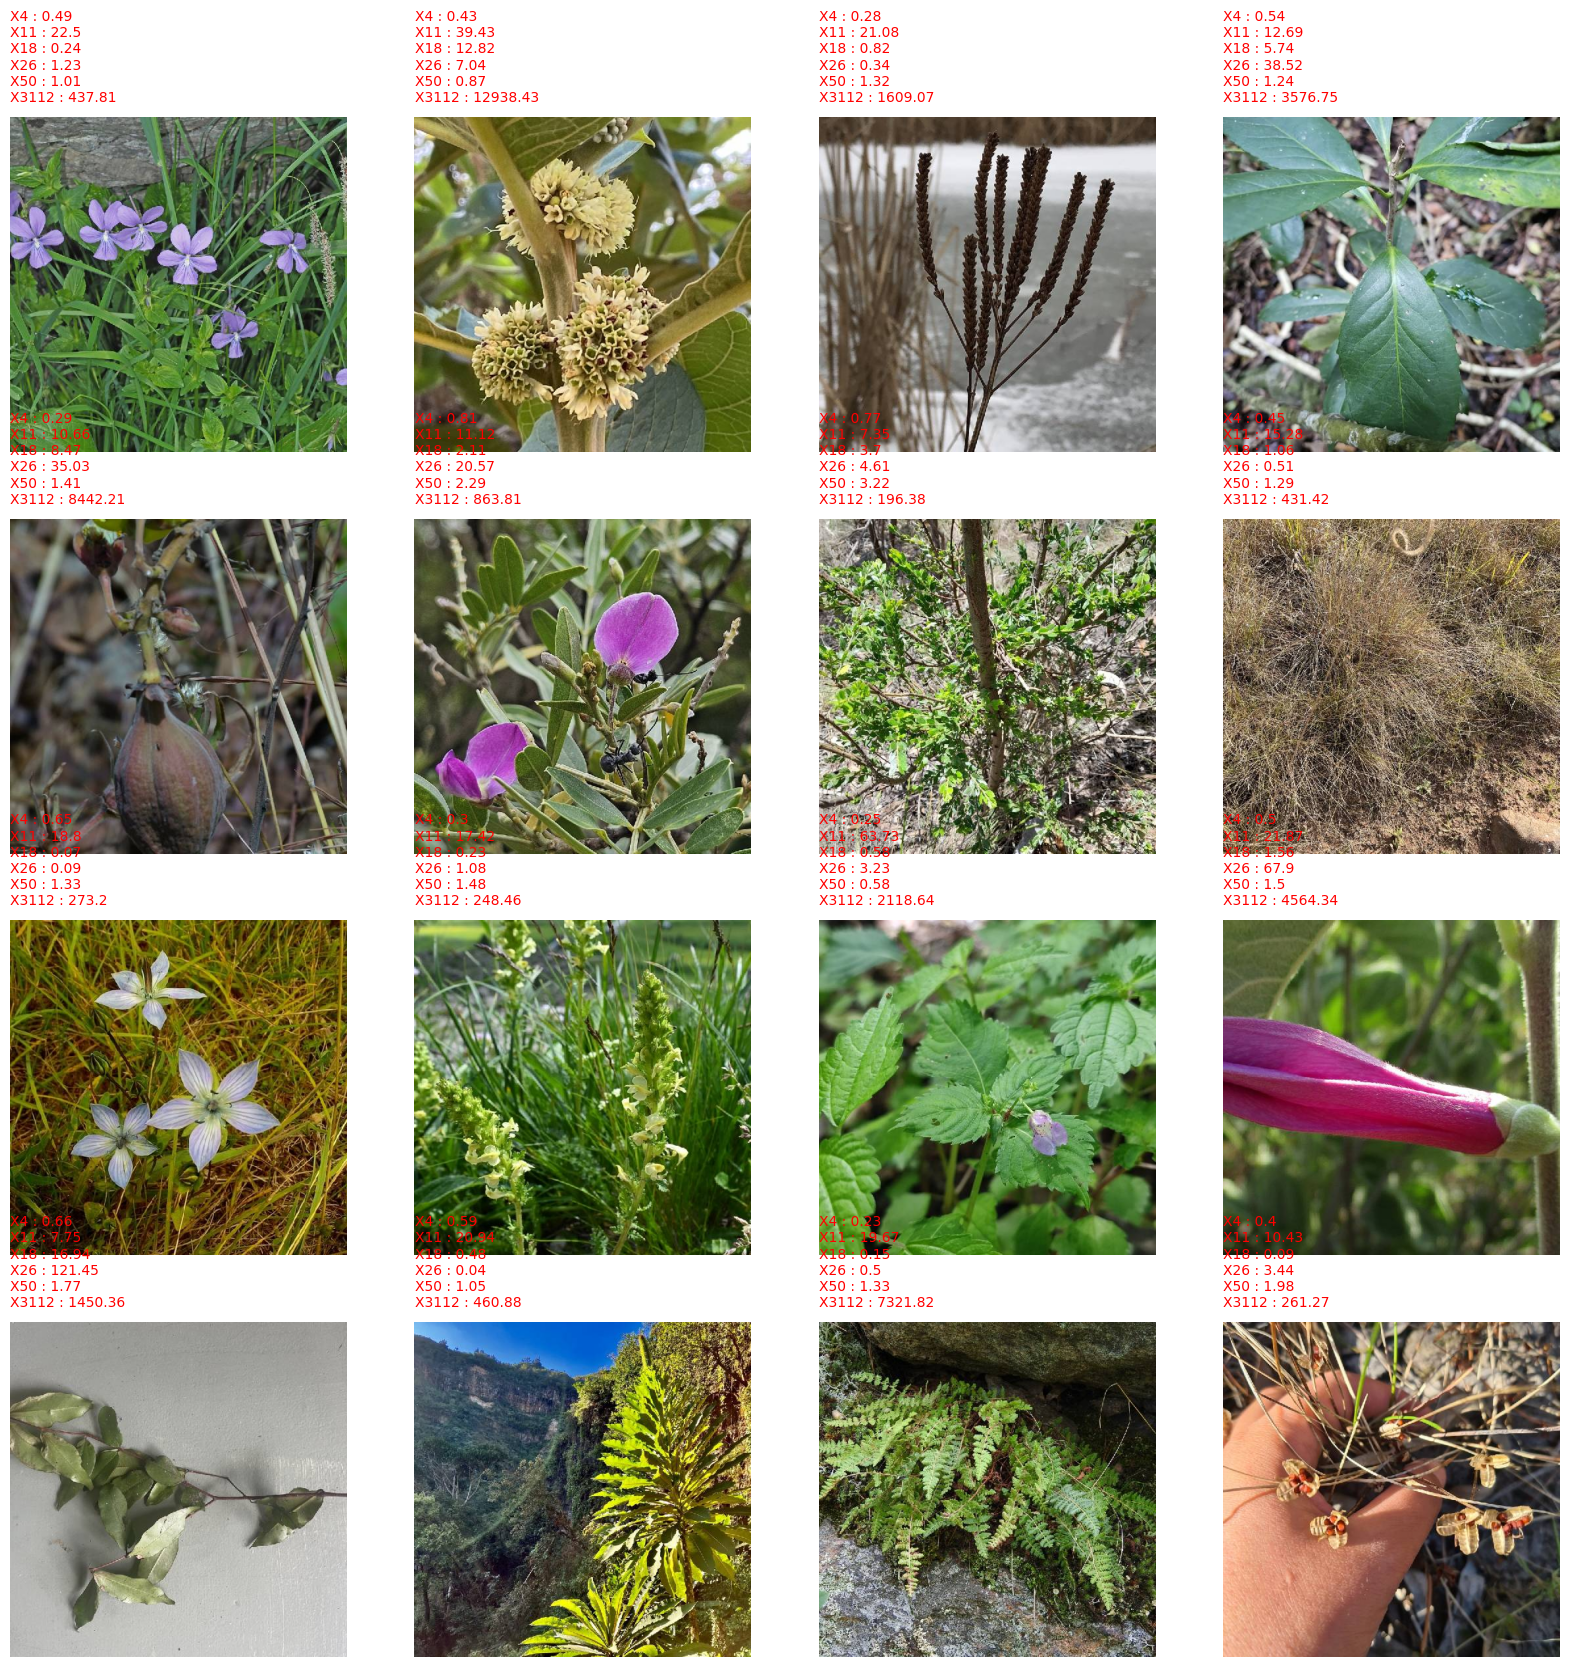

In [14]:
train_path = "./train_images"

sample = train.sample(n=16).reset_index()
fig = plt.figure(figsize=(20, 20))
for i, row in sample.iterrows():
    ax = fig.add_subplot(4, 4, i+1)
    img = mpimg.imread(f'{train_path}/{row.image_id}')
    ax.axis('off')
    disp = ''
    for label in class_names:
        val = np.round(float(row[label]),2).astype(str)
        disp += label.split('_')[0] + ' : ' + val + '\n'
    ax.axes.text(ax.axes.get_xlim()[0], ax.axes.get_ylim()[1], disp, color='red')
    ax.imshow(img, aspect='auto')
#plt.tight_layout()
plt.show()

##Prepare the training and validation data##
**Normalize the target mean and sd columns**


In [15]:
for col in class_names:
    print(f"{col} mean = {train[col].mean(): .2f} std = {train[col].std(): .2f}")

X4_mean mean =  0.52 std =  0.17
X11_mean mean =  132.53 std =  12782.20
X18_mean mean =  19699.02 std =  2309746.82
X26_mean mean =  3459.40 std =  247191.90
X50_mean mean =  13.53 std =  1356.48
X3112_mean mean =  397555.22 std =  91524633.45


**We will store the mean and std dev values for the trait columns in a dictionary for de-normalizing the results later on**

In [16]:
train_mean = {}
train_std = {}
for col in class_names:
    train_mean[col] = train[col].mean()
    train_std[col] = train[col].std()
    train[col] = (train[col] - train_mean[col]) / train_std[col]
### Normalize the auxilliary input data
aux_train = train.drop(columns=class_names+aux_class_names+['id', 'image_id'])
aux_cols = aux_train.columns.tolist()
train[aux_cols] = train[aux_cols].apply(lambda x: (x - x.mean()) / (x.std()))
train[aux_cols].head()

WORLDCLIM_BIO1_annual_mean_temperature  \
0                               -0.308722   
1                                0.355131   
2                               -0.042540   
3                                0.541078   
4                               -1.833255   

   WORLDCLIM_BIO12_annual_precipitation  \
0                             -0.889794   
1                             -1.259403   
2                             -0.203695   
3                              0.539957   
4                             -0.687422   

   WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                                              -0.554507   
1                                                              -0.936983   
2                                                              -0.648940   
3                                                               0.182800   
4                                                              -0.640034   

   WORLDCLIM_BIO15_precipitation_seasonality  \
0                                   0.490016   
1                                  -0.583940   
2                                  -1.225971   
3                                  -0.369728   
4                                  -0.583632   

   WORLDCLIM_BIO4_temperature_seasonality  \
0                                0.805009   
1                                1.075370   
2                               -0.412906   
3                               -0.434774   
4                                2.541910   

   WORLDCLIM_BIO7_temperature_annual_range  SOIL_bdod_0.5cm_mean_0.01_deg  \
0                                 0.879727                       0.460268   
1                                 1.615365                       0.403475   
2                                -0.264450                      -0.562003   
3                                -0.523483                       0.176304   
4                                 2.258144                      -1.470688   

   SOIL_bdod_100.200cm_mean_0.01_deg  SOIL_bdod_15.30cm_mean_0.01_deg  \
0                           0.579812                         0.487337   
1                           0.248142                         0.612098   
2                          -0.481532                        -0.573135   
3                          -0.614201                        -0.198851   
4                           0.380810                        -0.510754   

   SOIL_bdod_30.60cm_mean_0.01_deg  ...  VOD_X_1997_2018_multiyear_mean_m03  \
0                         0.633991  ...                            0.638737   
1                         0.505865  ...                           -0.768716   
2                        -0.583205  ...                            0.488968   
3                        -0.262890  ...                           -0.321263   
4                         0.185551  ...                           -0.128924   

   VOD_X_1997_2018_multiyear_mean_m04  VOD_X_1997_2018_multiyear_mean_m05  \
0                            0.927596                            1.040207   
1                           -0.881655                           -0.942058   
2                            0.413612                            0.405369   
3                           -0.438930                           -0.559981   
4                            0.260016                            0.553302   

   VOD_X_1997_2018_multiyear_mean_m06  VOD_X_1997_2018_multiyear_mean_m07  \
0                            0.817110                            0.347123   
1                           -1.069338                           -1.022191   
2                            0.406564                            0.344941   
3                           -0.635200                           -0.534971   
4                            1.199767                            1.516908   

   VOD_X_1997_2018_multiyear_mean_m08  VOD_X_1997_2018_multiyear_mean_m09  \
0                            0.213266                            0.384473   

**Split training set into train and validation sets (80/20)**

In [17]:
### Split the training dataset into train and valid datasets
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=1)

**Check the shapes of the training and validation sets**

In [18]:
print(train_df.shape)
print(valid_df.shape)
#valid_df.head()

(44391, 177)
(11098, 177)


Remove outliers (0.99 and 0.01 quantiles) from the training and validation datasets

In [19]:
upper_quantile = []
for col in class_names:
    #print(train_df[[col]].describe())
    upper_quantile = train_df[[col]].quantile(0.99,interpolation='nearest')
    lower_quantile = train_df[[col]].quantile(0.01,interpolation='nearest')
    #print(upper_quantile)
    #print(lower_quantile)
    train_df = train_df[train_df[col] < upper_quantile[0]]
    train_df = train_df[train_df[col] > lower_quantile[0]]
    upper_quantile2 = valid_df[[col]].quantile(0.99,interpolation='nearest')
    lower_quantile2 = valid_df[[col]].quantile(0.01,interpolation='nearest')
    valid_df = valid_df[valid_df[col] < upper_quantile2[0]]
    valid_df = valid_df[valid_df[col] > lower_quantile2[0]]

In [20]:
print(train_df.shape)
print(valid_df.shape)

(39294, 177)
(9817, 177)


#### Display the distribution of the train and valid label values

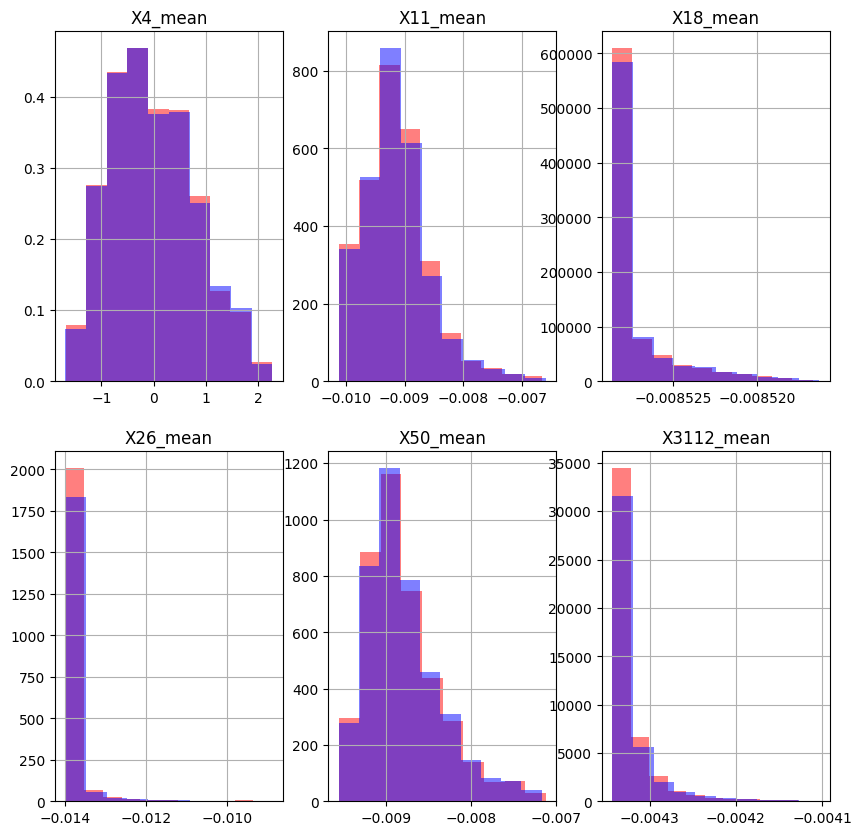

In [21]:
fig, axs = plt.subplots(2,3,figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    #ax.axes.hist(train_df[class_names[i]])
    #ax.axis('off')
    col = class_names[i]
#    train_df[col] = train_df[class_names[i]].astype(float).apply(lambda x: np.log(x))
#    valid_df[col] = valid_df[class_names[i]].astype(float).apply(lambda x: np.log(x))
#    col_sd = aux_class_names[i]
#    train_df[col_sd] = train_df[col_sd].astype(float).apply(lambda x: np.log(x))
#    valid_df[col_sd] = valid_df[col_sd].astype(float).apply(lambda x: np.log(x))

    train_df[col].hist(ax=ax,density=True,bins=10,color='red', alpha=0.5)
    valid_df[col].hist(ax=ax,density=True,bins=10,color='blue', alpha=0.5)
    ax.set_title(col)
#plt.tight_layout()
plt.show()

X18, X26 and X3112 could use logarithmic values to get a better distribution of the data. For now we will proceed with the normalized raw values and later revisit the above 3 trait values

### Generate image data using keras image library function ImageDataGenerator

We will use the built-in image processing library from Keras to process all the images from the train_images and valid_images directories

## Build the model
---




#### Define the model

The input data has two parts:
1. Image data in jpeg files in the train_images directory
2. Auxiliary data such as climate, satellite etc

The problem given is a multi-target regression problem with the above 2 sets of data as input and the plant traits mean values as targets.

To solve this problem we will first use Convolutional Neural network (CNN) to derive the image features from the input plant images

Next we will use the provided auxilliary data to create a Dense layer model with `relu` activation function

Finally we will concatenate the image features and the auxilliary data and feed it into a linear regression model to produce the output values.



For processing the images CNN architecture will have the following layers:


1.   3 sets of Convolution 2D layers with "relu" activation function with 32, 64 and 96 filters in each layer
2.   Each set of Conv2D layers is following by a layer of  Max Pooling
3.   Flatten the output into a 2 dimensional matrix
4.   Drop 20% of the parameters
5.   Apply a Dense layer with a relu activation function


In [91]:
np.random.seed(1)
tf.random.set_seed(1)
#### Image data layers
image_model = Sequential()
image_model.add(layers.Input(shape=(96,96,3), name='image_input'))
image_model.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
image_model.add(MaxPooling2D(pool_size=(2,2)))
image_model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
image_model.add(MaxPooling2D(pool_size=(2,2)))
image_model.add(Conv2D(96, kernel_size=(3,3), activation="relu"))
image_model.add(MaxPooling2D(pool_size=(2,2)))
image_model.add(Flatten())
image_model.add(Dropout(0.2))
image_input = image_model.inputs
image_features = image_model.output
### Auxilliary data layers
aux_model = Sequential()
aux_model.add(layers.Input(shape=(len(aux_cols),), name='aux_input'))
aux_model.add(Dense(128, activation="relu"))
aux_model.add(Dropout(0.2))
aux_input = aux_model.inputs
aux_features = aux_model.output

### combine the image and auxilliary features
combined_model = layers.Concatenate(axis=1)([image_features, aux_features])
combined_model = Dense(256, activation="relu")(combined_model)
combined_model = Dense(len(class_names), activation='linear', name='output')(combined_model)
#combined_model = Dense(y_train.shape[1], activation='linear', name='out')(combined_model)

### Define the output layers and compile the model
#combined_model.add(Dense(y_train.shape[1], activation='linear', name='out'))

model = Model(inputs=[image_input, aux_input], outputs=combined_model)
opt = keras.optimizers.Adam(learning_rate=0.00001)
#model.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.R2Score()])
model.compile(optimizer=opt, loss='mse', metrics=[keras.metrics.CosineSimilarity(axis=1)])
#
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d_27 (Conv2D)          (None, 94, 94, 32)           896       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d_27 (MaxPooli  (None, 47, 47, 32)           0         ['conv2d_27[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 45, 45, 64)           18496     ['max_pooling2d_27[0][0]

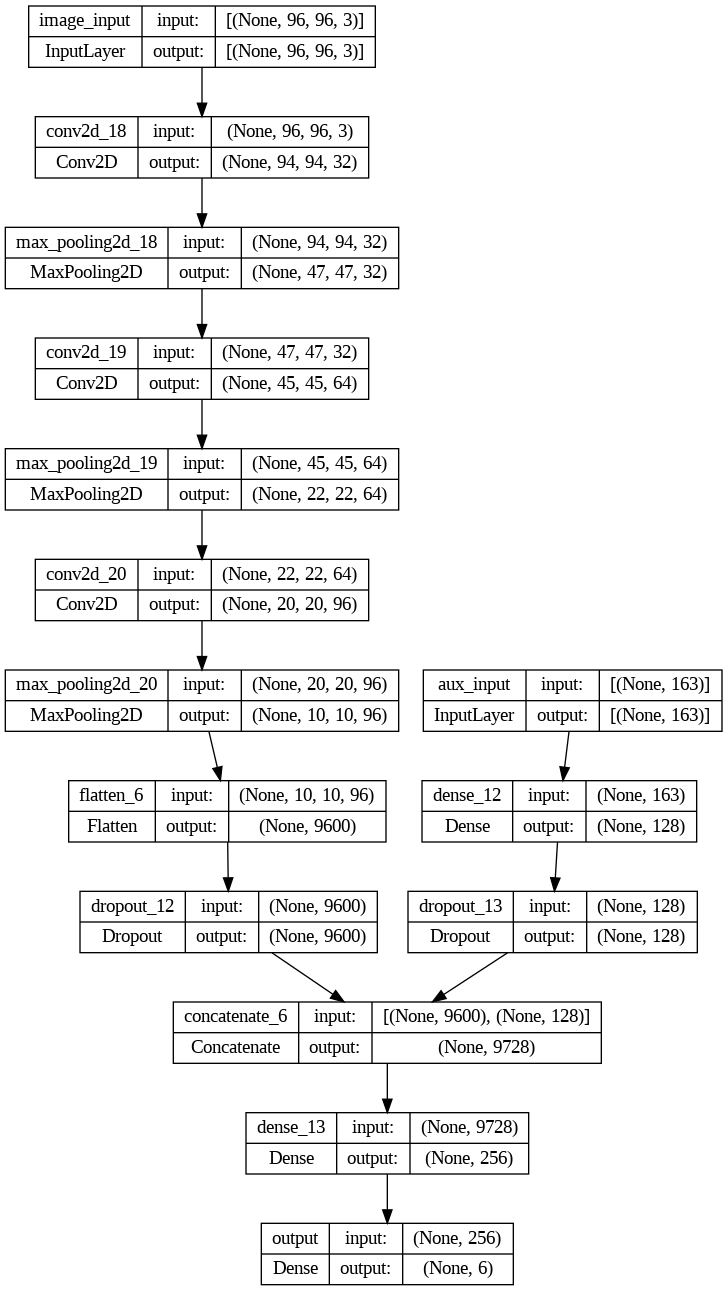

In [67]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Fit the model
Before we can fit the model, we have to combine the image data generator output with the auxilliary tabular data.

In [92]:
BATCH_SIZE = 64
IMAGE_SIZE = (96,96)
train_datagen = ImageDataGenerator(rescale=1.0/255)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

def create_generator(image_datagen, dataframe, batch_size):
    while True:
        list_df = [dataframe[i:i+batch_size] for i in range(0,dataframe.shape[0],batch_size)]
        for batch in list_df:
            batch_indices = batch.index
            images_gen = image_datagen.flow_from_dataframe(
                              dataframe = batch,
                              directory = train_path,
                              x_col = 'image_id',
                              y_col = aux_cols,
                              batch_size = batch_size,
                              shuffle = False,
                              target_size = IMAGE_SIZE,
                              seed = 1,
                              class_mode = 'raw',)
            # Get the target labels
            targets = dataframe.loc[batch_indices, class_names].values
            images = images_gen.next()
            yield images, tf.convert_to_tensor(targets, dtype=tf.float32)



# Create the generator
train_generator = create_generator(train_datagen, train_df, BATCH_SIZE)
valid_generator = create_generator(validation_datagen, valid_df, BATCH_SIZE)



In [93]:
history = model.fit(train_generator,
                    steps_per_epoch=np.ceil(len(train_df)/BATCH_SIZE),
                    validation_data=valid_generator,
                    validation_steps=np.ceil(len(valid_df)/BATCH_SIZE),
                    epochs=5,
                    batch_size=BATCH_SIZE,
                    )

Found 64 validated image filenames.
Epoch 1/5
Found 64 validated image filenames.
Found 64 validated image filenames.
  1/614 [..............................] - ETA: 18:35 - loss: 0.1476 - cosine_similarity: -6.9066e-04Found 64 validated image filenames.
Found 64 validated image filenames.
614/614 [==============================] - ETA: 0s - loss: 0.0998 - cosine_similarity: 0.2089Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Foun

### Plot the model accuracy and loss by epoch

In [94]:
print(history.history.keys())

dict_keys(['loss', 'cosine_similarity', 'val_loss', 'val_cosine_similarity'])


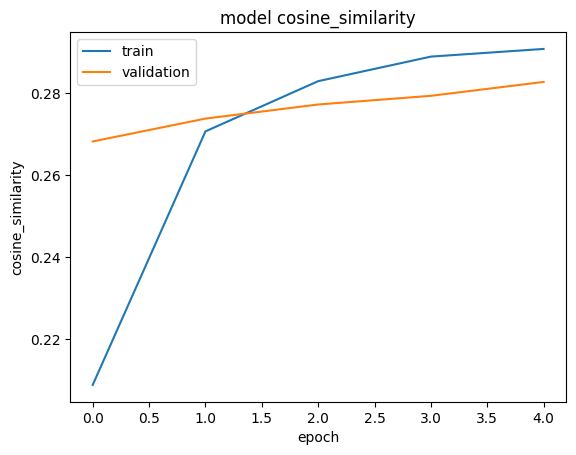

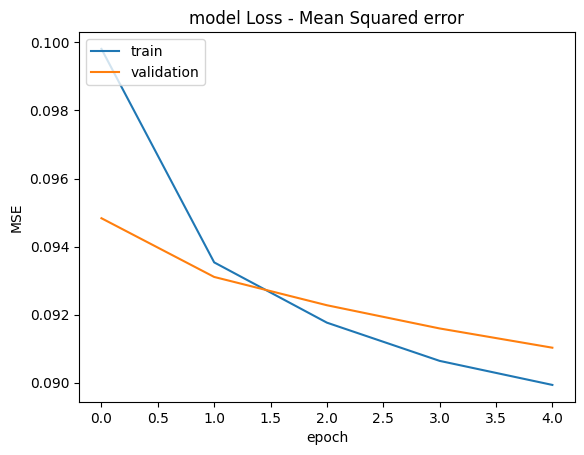

In [95]:

#  "cosine_similarity"
plt.plot(history.history['cosine_similarity'])
plt.plot(history.history['val_cosine_similarity'])
plt.title('model cosine_similarity')
plt.ylabel('cosine_similarity')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss - Mean Squared error')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

**save the model for later use**

In [96]:
### Save the model
model.save("model_9.keras")

In [97]:
!cp 'model_9.keras' '/gdrive/MyDrive/kaggle/'
os.listdir('/gdrive/MyDrive/kaggle/')

['histopathologic-cancer-detection.zip',
 'nlp-getting-started.zip',
 'planttraits2024.zip',
 'kaggle.json',
 'week3_submission.csv',
 'week4_submission.csv',
 'learning-agency-lab-automated-essay-scoring-2.zip',
 'model2.keras',
 'model.keras',
 'submission.csv',
 'model_8.keras',
 'model_9.keras']

## Predict test output values
**Copy the model from google drive and load into memory**

Only need to run this cell if the notebook is run in two stages before and after creating the model

In [ ]:
#import os
#from google.colab import drive
#drive.mount('/gdrive')

gdrive_path = '/gdrive/MyDrive/kaggle/'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
print(os.getcwd())
# Copy the .zip file into the present directory
full_path = gdrive_path+'model.keras'
!cp '{full_path}' .

model = tf.keras.models.load_model('model.keras')
model.summary()

/content
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 94, 94, 32)           896       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 47, 47, 32)           0         ['conv2d_9[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 45, 45, 64)           18496     ['max_pooling2d

**Read the `test.csv` file and normalize the auxilliary data fields**

In [98]:
df_test = pd.read_csv('./test.csv')
#df_test.set_index('id',drop=True,inplace=True)
df_test['image_id'] = df_test.id.astype(str) + '.jpeg'

x_cols = df_test.drop(columns=['id', 'image_id']).columns.tolist()
df_test[x_cols] = df_test[x_cols].fillna(0)
df_test[x_cols] = df_test[x_cols].apply(lambda x: (x - x.mean()) / (x.std()))
df_test.head()


id  WORLDCLIM_BIO1_annual_mean_temperature  \
0  201238668                               -0.750977   
1  202310319                               -0.373016   
2  202604412                               -0.748400   
3  201353439                               -0.889286   
4  195351745                               -1.202770   

   WORLDCLIM_BIO12_annual_precipitation  \
0                              1.584028   
1                             -0.749869   
2                             -0.906574   
3                             -0.239376   
4                              1.654508   

   WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                                               0.009998   
1                                                              -0.703292   
2                                                              -0.617776   
3                                                              -0.398684   
4                                                               0.174343   

   WORLDCLIM_BIO15_precipitation_seasonality  \
0                                  -1.017968   
1                                  -1.072923   
2                                  -0.318045   
3                                  -0.475900   
4                                  -0.896876   

   WORLDCLIM_BIO4_temperature_seasonality  \
0                               -0.637688   
1                                0.824331   
2                                0.606691   
3                                0.428883   
4                               -0.268088   

   WORLDCLIM_BIO7_temperature_annual_range  SOIL_bdod_0.5cm_mean_0.01_deg  \
0                                -0.941486                      -1.926361   
1                                 0.454134                       0.776326   
2                                 1.114242                       0.938487   
3                                -0.037639                      -0.683125   
4                                -0.350227                      -1.656093   

   SOIL_bdod_100.200cm_mean_0.01_deg  SOIL_bdod_15.30cm_mean_0.01_deg  ...  \
0                          -2.073699                        -2.267567  ...   
1                           0.906973                         0.843024  ...   
2                          -0.453769                         0.663567  ...   
3                          -0.064985                        -0.712272  ...   
4                          -1.749713                        -1.789015  ...   

   VOD_X_1997_2018_multiyear_mean_m04  VOD_X_1997_2018_multiyear_mean_m05  \
0                            0.021618                           -0.045668   
1                           -0.696356                           -0.471370   
2                            0.256900                            0.340207   
3                           -0.592253                           -0.319501   
4                            0.973229                            0.534626   

   VOD_X_1997_2018_multiyear_mean_m06  VOD_X_1997_2018_multiyear_mean_m07  \
0                           -0.162652                           -0.259027   
1                           -0.603583                           -0.786818   
2                            0.407992                            0.334056   
3                            0.028377                            0.830422   
4                           -0.001342                           -0.298675   

   VOD_X_1997_2018_multiyear_mean_m08  VOD_X_1997_2018_multiyear_mean_m09  \
0                           -0.227806                           -0.105576   
1                           -0.837300                           -0.854830   
2                            0.288032                            0.286836   
3                            0.897942                            0.590403   
4                           -0.193895                            0.151883   

   VOD_X_1997_2018_multiyear_mean_m10  VOD_X_1997_2018_multiyear_mean_m11  \

In [99]:
df_test.shape

(6545, 165)

**Read the label metadata file**

In [ ]:
label_names = pd.read_table('./target_name_meta.tsv')
pd.set_option('display.max_colwidth', None)
label_names

trait_ID  \
0       X4   
1      X11   
2      X18   
3      X26   
4      X50   
5    X3112   

                                                                           trait_name   
0   Stem specific density (SSD) or wood density (stem dry mass per stem fresh volume)   
1                      Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA)   
2                                                                        Plant height   
3                                                                       Seed dry mass   
4                                             Leaf nitrogen (N) content per leaf area   
5  Leaf area (in case of compound leaves: leaf, undefined if petiole in- or excluded)

**Generate the image data and combine with auxilliary data**

In [100]:
test_path = './test_images'
BATCH_SIZE = 64
IMAGE_SIZE = (96,96)

test_datagen = ImageDataGenerator(rescale=1./255)

def create_test_generator(image_datagen, dataframe, batch_size):
    while True:
        list_df = [dataframe[i:i+batch_size] for i in range(0,dataframe.shape[0],batch_size)]
        for batch in list_df:
            batch_indices = batch.index
            images_gen = image_datagen.flow_from_dataframe(
                          dataframe = batch,
                          directory = test_path,
                          x_col = 'image_id',
                          y_col = aux_cols,
                          batch_size = batch_size,
                          shuffle = False,
                          target_size = IMAGE_SIZE,
                          seed = 1,
                          class_mode = 'raw',)
            # Get the target labels
            targets = dataframe.loc[batch_indices, aux_cols].values
            images = images_gen.next()
            yield images, tf.convert_to_tensor(targets, dtype=tf.float32)

# Create the generator
test_generator = create_test_generator(test_datagen, df_test, BATCH_SIZE)


In [101]:
test_results = model.predict(test_generator,steps=np.ceil(len(df_test)/BATCH_SIZE))
print(test_results.shape)
test_ds = pd.DataFrame(test_results, columns=label_names.trait_ID)


Found 64 validated image filenames.
103/103 [==============================] - 15s 142ms/step
Found 64 validated image filenames.
(6545, 6)


In [102]:
test_ds['id'] = df_test.id
test_ds.head()

trait_ID        X4       X11       X18       X26       X50     X3112  \
0         0.332390  0.021790  0.005059 -0.017635  0.023876 -0.008325   
1        -0.355423 -0.006891 -0.004753 -0.031510 -0.005668 -0.018554   
2        -0.203742  0.000732 -0.030190 -0.027765  0.050655 -0.023990   
3        -0.422136 -0.013911 -0.006736  0.000259  0.009731 -0.022939   
4        -0.059020 -0.048544 -0.043519 -0.012735  0.018050  0.028666   

trait_ID         id  
0         201238668  
1         202310319  
2         202604412  
3         201353439  
4         195351745

**De-normalize the predicted results data**

In order to do that we first store the mean and std values of the label columns (_mean) from the train dataset. We will use it for de-normalizing the results

In [103]:
#train = pd.read_csv('./train.csv')

#class_names = list(label_names.trait_ID.astype(str)+'_mean')
#print(class_names)

#train_mean = {}
#train_std = {}
#for col in class_names:
#    train_mean[col] = train[col].mean()
#    train_std[col] = train[col].std()

for label in label_names.trait_ID:
    dict_label = label + '_mean'
    test_ds[label] = test_ds[label] * train_std[dict_label] + train_mean[dict_label]

##Re-arrange the columns in the test output
test_labels = []
test_labels.append('id')
for label in label_names.trait_ID:
    test_labels.append(label)
test_ds = test_ds[test_labels]
print(test_ds.shape)
test_ds.head()

(6545, 7)


trait_ID         id        X4         X11           X18          X26  \
0         201238668  0.580695  411.055054  31384.085938  -899.791016   
1         202310319  0.460429   44.442841   8720.495117 -4329.553223   
2         202604412  0.486951  141.882263 -50032.890625 -3403.835449   
3         201353439  0.448764  -45.292374   4140.538086  3523.302734   
4         195351745  0.512256 -487.973938 -80818.351562   311.292480   

trait_ID        X50         X3112  
0         45.915504 -3.643932e+05  
1          5.839647 -1.300593e+06  
2         82.241203 -1.798078e+06  
3         26.728207 -1.701956e+06  
4         38.012421  3.021195e+06

#### Check the model accuracy against the sample submission dataset
We will read the sample submission file and evaluate the output against the sample results given

**Check the sample submission file**

In [104]:
df_samples = pd.read_csv('./sample_submission.csv')
#test_data = df_samples.astype(str)
#test_data = test_data.sample(1000)
#test_data['id'] += '.tif'
df_samples.head()

id         X4        X11        X18        X50        X26      X3112
0  201238668  21.228750  46.704747  31.430122  14.088638  24.208952  93.351051
1  202310319   4.938497  71.644437  50.208404  99.503446  86.561125  20.325735
2  202604412  34.268159  93.046483  74.556941  84.275746  85.713291  23.470287
3  201353439  48.213879  84.687775  -1.442158  -9.852137  13.327949  -0.274766
4  195351745  55.117501  87.046172  84.335483  79.218376  19.142174  11.294033

#### Copy the predicted values into output file for submission

In [105]:
pd.isnull(test_ds).sum()

trait_ID
id       0
X4       0
X11      0
X18      0
X26      0
X50      0
X3112    0
dtype: int64

In [106]:
test_ds.shape

(6545, 7)

In [107]:
test_ds.to_csv('submission.csv', index=False)
!cp submission.csv '/gdrive/MyDrive/kaggle/'

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 398, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
